In [1]:
import yfinance as yf, tensorflow as tf, numpy as np
import keras
from tensorflow.keras.utils import timeseries_dataset_from_array as loader
from keras.layers import SimpleRNN, LSTM, Dense
from keras import Sequential
from UTILS import nll, train_test_split_ts, forward_garch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
from arch import arch_model
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,4)
plt.rcParams['font.size'] = 15

In [25]:
prices = yf.Ticker('^GSPC').history(start = '2010-01-01').Close
rets = 100*(prices.pct_change().dropna())
rets_train, rets_test = train_test_split_ts(rets, .97)

# garch = arch_model(rets_train.values, mean = 'Constant', vol = 'GARCH', p=1, q=1)
# fit = garch.fit(disp = False)
# tf_garch_vola_train= tf.convert_to_tensor(fit.conditional_volatility.reshape(-1,1), dtype = 'float32')
# tf_garch_vola_train = tf.math.log(tf_garch_vola_train)

tf_rets_train = tf.convert_to_tensor(rets_train.values.reshape(-1,1), dtype = 'float32')
tf_rets_train -= tf.math.reduce_mean(tf_rets_train)
tf_rets_test = tf.convert_to_tensor(rets_test.values.reshape(-1,1), dtype = 'float32')
tf_rets_test -= tf.math.reduce_mean(tf_rets_test)

In [26]:
# tst = tf.concat((tf_rets_train[:], vola[:]), 1)

In [27]:
# lag = 10
# data_train = loader(tst,
#                     targets = tf_rets_train[lag:],
#                     sequence_length = lag,
#                     batch_size = tf_rets_test.shape[0]//5)
# all_train = loader(tst,
#                     targets = tf_rets_train[lag:],
#                     sequence_length = lag,
#                     batch_size = tf_rets_train.shape[0])
# for X, y in all_train:
#     print(X)
#     print(y)
#     break

In [28]:
# Create Data to Load
lag = 10
data_test = loader(tf_rets_test,
                    targets = tf_rets_test[lag:],
                    sequence_length = lag,
                    batch_size = tf_rets_test.shape[0]//5)
all_test = loader(tf_rets_test,
                  targets = tf_rets_test[lag:], 
                  sequence_length = lag, 
                  batch_size = tf_rets_test.shape[0])
data_train = loader(tf_rets_train,
                    targets = tf_rets_train[lag:],
                    sequence_length = lag,
                    batch_size = tf_rets_train.shape[0]//5)
all_train = loader(tf_rets_train,
                  targets = tf_rets_train[lag:], 
                  sequence_length = lag, 
                  batch_size = tf_rets_train.shape[0])

In [29]:
# Fit GARCH
for X, y in all_train:
    garch = arch_model(y.numpy(), mean = 'Constant', vol = 'GARCH', p=1, q=1)
    fit = garch.fit(disp = False)
    garch_vola_train = tf.convert_to_tensor(fit.conditional_volatility.reshape(-1,1), dtype = 'float32')

In [114]:
# data_with_garch_vola = tf.concat((y, garch_vola), 1)
# data_aug = loader(data_with_garch_vola, targets = y[lag:], sequence_length = lag, batch_size = rets.shape[0]//5)

In [30]:
model = Sequential(
    [
        SimpleRNN(units = 50, activation = 'tanh'),
        Dense(units = 10, activation = 'tanh'),
        Dense(units = 1, activation = 'exponential')
    ],
    name = 'Vola_Learner'
)

In [31]:
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate = .01)

In [32]:
model.compile(optimizer = optimizer, loss = nll)
loss_to_plot = []
loss_to_plot_test = []
for epoch in tqdm(range(1, epochs+1)):
    for batch, (X, y) in tqdm(enumerate(data_train)):
        with tf.GradientTape() as tape:
            logits = model(X)
            loss = nll(logits**2, y)
        gradients = tape.gradient(loss, model.trainable_weights)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    for X, y in all_train:
        loss = nll(model(X), y)
        loss_to_plot.append(loss.numpy())
#     for X, y in all_test:
#         loss_test = nll(model(X), y)
#         loss_to_plot_test.append(loss_test.numpy())
    print('EPOCH:{}'.format(epoch))
    print('NLL train:{:6.0f}'.format(loss))
#     print('NLL test :{:6.0f}'.format(loss_test))
    print(30*'=')

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

EPOCH:1
NLL train:  4365


0it [00:00, ?it/s]

EPOCH:2
NLL train:  4386


0it [00:00, ?it/s]

EPOCH:3
NLL train:  4067


0it [00:00, ?it/s]

EPOCH:4
NLL train:  4049


0it [00:00, ?it/s]

EPOCH:5
NLL train:  4043


0it [00:00, ?it/s]

EPOCH:6
NLL train:  4000


0it [00:00, ?it/s]

EPOCH:7
NLL train:  3934


0it [00:00, ?it/s]

EPOCH:8
NLL train:  3931


0it [00:00, ?it/s]

EPOCH:9
NLL train:  3903


0it [00:00, ?it/s]

EPOCH:10
NLL train:  3887


0it [00:00, ?it/s]

EPOCH:11
NLL train:  3865


0it [00:00, ?it/s]

EPOCH:12
NLL train:  3841


0it [00:00, ?it/s]

EPOCH:13
NLL train:  3835


0it [00:00, ?it/s]

EPOCH:14
NLL train:  3823


0it [00:00, ?it/s]

EPOCH:15
NLL train:  3803


0it [00:00, ?it/s]

EPOCH:16
NLL train:  3791


0it [00:00, ?it/s]

EPOCH:17
NLL train:  3784


0it [00:00, ?it/s]

EPOCH:18
NLL train:  3766


0it [00:00, ?it/s]

EPOCH:19
NLL train:  3755


0it [00:00, ?it/s]

EPOCH:20
NLL train:  3749


0it [00:00, ?it/s]

EPOCH:21
NLL train:  3735


0it [00:00, ?it/s]

EPOCH:22
NLL train:  3723


0it [00:00, ?it/s]

EPOCH:23
NLL train:  3713


0it [00:00, ?it/s]

EPOCH:24
NLL train:  3708


0it [00:00, ?it/s]

EPOCH:25
NLL train:  3696


0it [00:00, ?it/s]

EPOCH:26
NLL train:  3682


0it [00:00, ?it/s]

EPOCH:27
NLL train:  3672


0it [00:00, ?it/s]

EPOCH:28
NLL train:  3664


0it [00:00, ?it/s]

EPOCH:29
NLL train:  3658


0it [00:00, ?it/s]

EPOCH:30
NLL train:  3642


0it [00:00, ?it/s]

EPOCH:31
NLL train:  3629


0it [00:00, ?it/s]

EPOCH:32
NLL train:  3616


0it [00:00, ?it/s]

EPOCH:33
NLL train:  3609


0it [00:00, ?it/s]

EPOCH:34
NLL train:  3604


0it [00:00, ?it/s]

EPOCH:35
NLL train:  3595


0it [00:00, ?it/s]

EPOCH:36
NLL train:  3577


0it [00:00, ?it/s]

EPOCH:37
NLL train:  3557


0it [00:00, ?it/s]

EPOCH:38
NLL train:  3543


0it [00:00, ?it/s]

EPOCH:39
NLL train:  3539


0it [00:00, ?it/s]

EPOCH:40
NLL train:  3547


0it [00:00, ?it/s]

EPOCH:41
NLL train:  3562


0it [00:00, ?it/s]

EPOCH:42
NLL train:  3535


0it [00:00, ?it/s]

EPOCH:43
NLL train:  3496


0it [00:00, ?it/s]

EPOCH:44
NLL train:  3472


0it [00:00, ?it/s]

EPOCH:45
NLL train:  3497


0it [00:00, ?it/s]

EPOCH:46
NLL train:  3541


0it [00:00, ?it/s]

EPOCH:47
NLL train:  3521


0it [00:00, ?it/s]

EPOCH:48
NLL train:  3486


0it [00:00, ?it/s]

EPOCH:49
NLL train:  3463


0it [00:00, ?it/s]

EPOCH:50
NLL train:  3471


0it [00:00, ?it/s]

EPOCH:51
NLL train:  3467


0it [00:00, ?it/s]

EPOCH:52
NLL train:  3433


0it [00:00, ?it/s]

EPOCH:53
NLL train:  3425


0it [00:00, ?it/s]

EPOCH:54
NLL train:  3403


0it [00:00, ?it/s]

EPOCH:55
NLL train:  3381


0it [00:00, ?it/s]

EPOCH:56
NLL train:  3381


0it [00:00, ?it/s]

EPOCH:57
NLL train:  3355


0it [00:00, ?it/s]

EPOCH:58
NLL train:  3363


0it [00:00, ?it/s]

EPOCH:59
NLL train:  3345


0it [00:00, ?it/s]

EPOCH:60
NLL train:  3337


0it [00:00, ?it/s]

EPOCH:61
NLL train:  3329


0it [00:00, ?it/s]

EPOCH:62
NLL train:  3311


0it [00:00, ?it/s]

EPOCH:63
NLL train:  3298


0it [00:00, ?it/s]

EPOCH:64
NLL train:  3285


0it [00:00, ?it/s]

EPOCH:65
NLL train:  3286


0it [00:00, ?it/s]

EPOCH:66
NLL train:  3283


0it [00:00, ?it/s]

EPOCH:67
NLL train:  3301


0it [00:00, ?it/s]

EPOCH:68
NLL train:  3358


0it [00:00, ?it/s]

EPOCH:69
NLL train:  3393


0it [00:00, ?it/s]

EPOCH:70
NLL train:  3354


0it [00:00, ?it/s]

EPOCH:71
NLL train:  3294


0it [00:00, ?it/s]

EPOCH:72
NLL train:  3267


0it [00:00, ?it/s]

EPOCH:73
NLL train:  3304


0it [00:00, ?it/s]

EPOCH:74
NLL train:  3319


0it [00:00, ?it/s]

EPOCH:75
NLL train:  3298


0it [00:00, ?it/s]

EPOCH:76
NLL train:  3264


0it [00:00, ?it/s]

EPOCH:77
NLL train:  3245


0it [00:00, ?it/s]

EPOCH:78
NLL train:  3261


0it [00:00, ?it/s]

EPOCH:79
NLL train:  3318


0it [00:00, ?it/s]

EPOCH:80
NLL train:  3200


0it [00:00, ?it/s]

EPOCH:81
NLL train:  3235


0it [00:00, ?it/s]

EPOCH:82
NLL train:  3186


0it [00:00, ?it/s]

EPOCH:83
NLL train:  3228


0it [00:00, ?it/s]

EPOCH:84
NLL train:  3217


0it [00:00, ?it/s]

EPOCH:85
NLL train:  3200


0it [00:00, ?it/s]

EPOCH:86
NLL train:  3194


0it [00:00, ?it/s]

EPOCH:87
NLL train:  3184


0it [00:00, ?it/s]

EPOCH:88
NLL train:  3140


0it [00:00, ?it/s]

EPOCH:89
NLL train:  3207


0it [00:00, ?it/s]

EPOCH:90
NLL train:  3268


0it [00:00, ?it/s]

EPOCH:91
NLL train:  3206


0it [00:00, ?it/s]

EPOCH:92
NLL train:  3212


0it [00:00, ?it/s]

EPOCH:93
NLL train:  3153


0it [00:00, ?it/s]

EPOCH:94
NLL train:  3141


0it [00:00, ?it/s]

EPOCH:95
NLL train:  3129


0it [00:00, ?it/s]

EPOCH:96
NLL train:  3164


0it [00:00, ?it/s]

EPOCH:97
NLL train:  3204


0it [00:00, ?it/s]

EPOCH:98
NLL train:  3187


0it [00:00, ?it/s]

EPOCH:99
NLL train:  3181


0it [00:00, ?it/s]

EPOCH:100
NLL train:  3113


# Train Set Performance

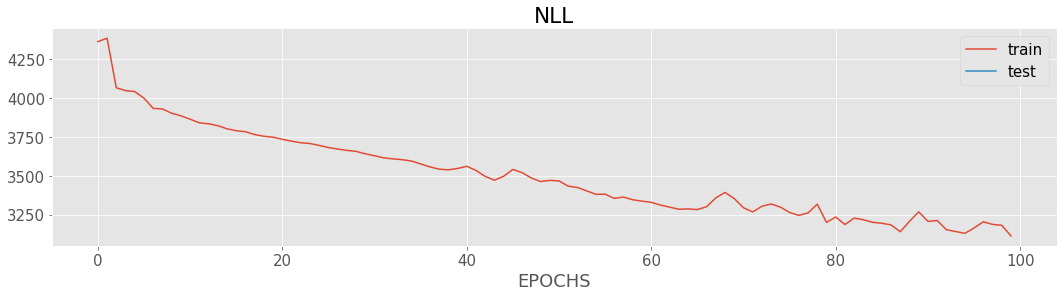

In [33]:
plt.plot(loss_to_plot, label = 'train')
plt.plot(loss_to_plot_test, label = 'test')
plt.legend()
plt.title('NLL')
plt.xlabel('EPOCHS')
plt.show()

NLL:   3113


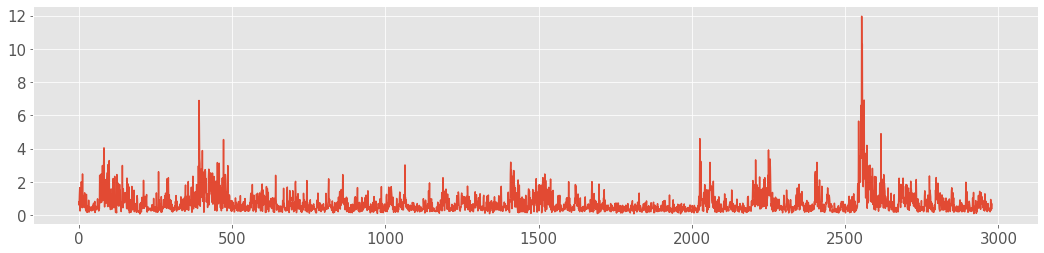

In [34]:
for X, y in all_train:
    y_train = y
    print('NLL: {:6.0f}'.format(nll(model(X), y)))
    plt.plot(model(X))
    plt.show()

NLL_GARCH:   3849


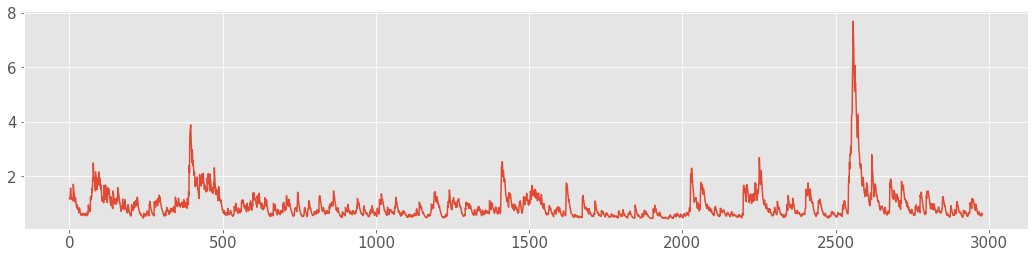

In [35]:
print('NLL_GARCH: {:6.0f}'.format(nll(garch_vola_train, y).numpy()))
plt.plot(garch_vola_train)
plt.show()

In [36]:
model.summary()

Model: "Vola_Learner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


# Test Set Performance

NLL:    164


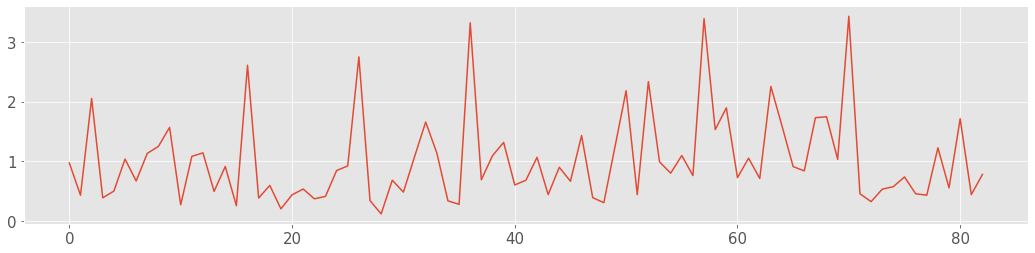

In [37]:
for X, y in all_test:
    y_test = y
    print('NLL: {:6.0f}'.format(nll(model(X), y)))
    plt.plot(model(X))
    plt.show()

NLL_GARCH:    141


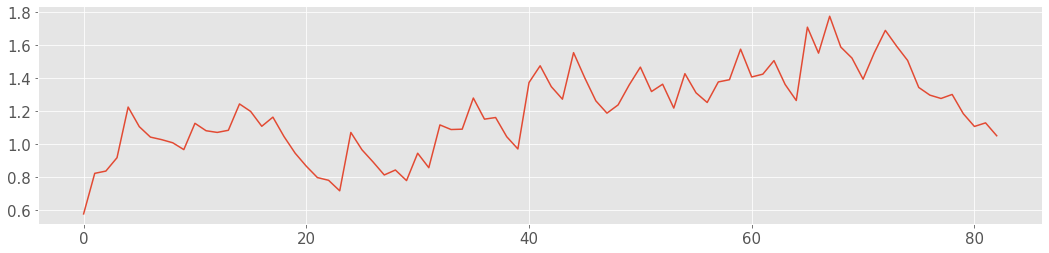

In [38]:
garch_test = forward_garch(y_test, y_train, fit)
plt.plot(garch_test)
print('NLL_GARCH: {:6.0f}'.format(nll(garch_test, y_test)))